Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mixed precision enabled (mixed_float16).
Detected classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Found 20657 files belonging to 15 classes.
Using 16526 files for training.
Found 20657 files belonging to 15 classes.
Using 4131 files for validation.
Number of classes: 15


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_128            │ (None, 4, 4, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576,111 (2.20 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 410,208 (1.56 MB)

Epoch 1/2
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5605 - loss: 1.4189 
Epoch 1: val_accuracy improved from -inf to 0.79981, saving model to /content/drive/MyDrive/best_quick_model.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 2441s 19s/step - accuracy: 0.5616 - loss: 1.4152 - val_accuracy: 0.7998 - val_loss: 0.6165 - learning_rate: 0.0010
Epoch 2/2
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8158 - loss: 0.5455
Epoch 2: val_accuracy improved from 0.79981 to 0.82910, saving model to /content/drive/MyDrive/best_quick_model.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8160 - loss: 0.5448 - val_accuracy: 0.8291 - val_loss: 0.5322 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


Final model saved to Drive at: /content/drive/MyDrive/final_quick_model.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8321 - loss: 0.5337
Validation loss: 0.5322  -  Validation accuracy: 0.8291
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step


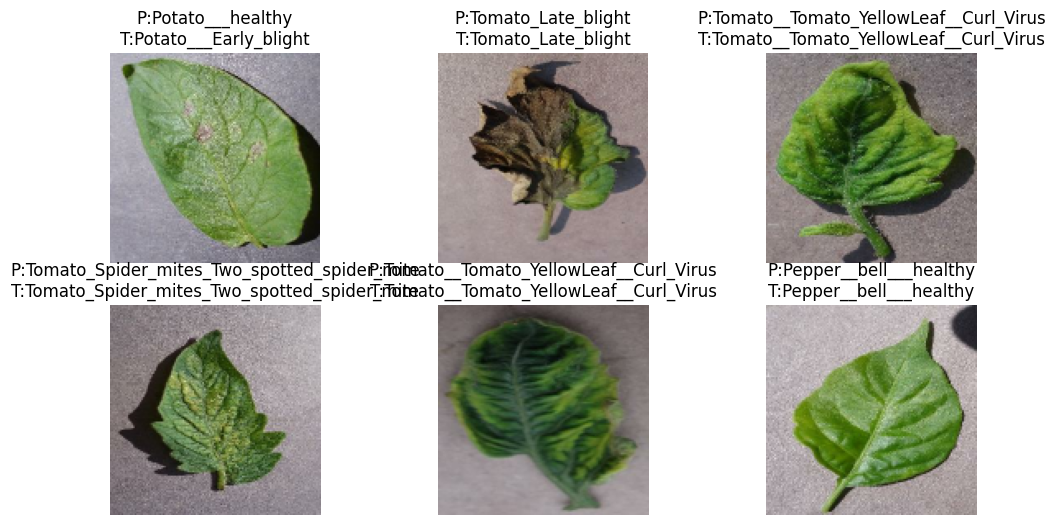

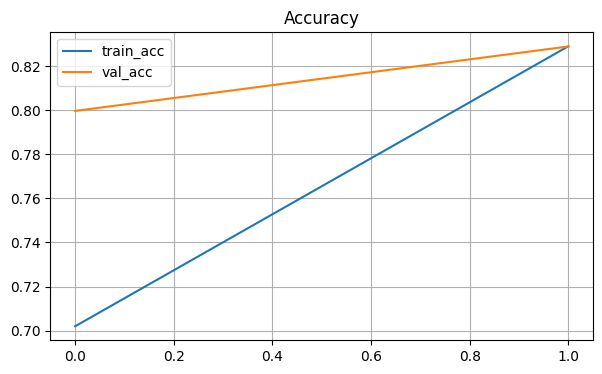

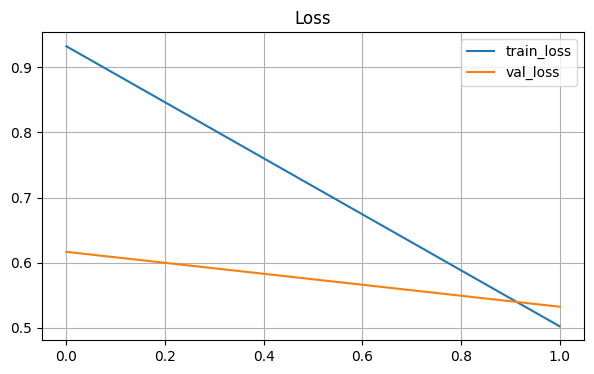

In [ ]:
# Colab-ready: fast MobileNetV2 training (notebook-style, minimal epochs)
# Adapted to be similar to the GitHub notebook you shared, but optimized for speed.
# Dataset expected at: /content/drive/MyDrive/data/PlantVillage

# --------------------------
# 0) Quick settings (edit if needed)
# --------------------------
DATA_DIR = '/content/drive/MyDrive/data/PlantVillage'   # <-- your dataset path
DRIVE_SAVE_DIR = '/content/drive/MyDrive'               # where models will be saved
BEST_MODEL_NAME = 'best_quick_model.h5'
FINAL_MODEL_NAME = 'final_quick_model.h5'
BEST_MODEL_PATH = f"{DRIVE_SAVE_DIR}/{BEST_MODEL_NAME}"
FINAL_MODEL_PATH = f"{DRIVE_SAVE_DIR}/{FINAL_MODEL_NAME}"

# SPEED / ACCURACY tradeoffs (change if you want better accuracy)
IMG_SIZE = (128, 128)     # smaller -> much faster (use (160,160) or (224,224) for better accuracy)
BATCH_SIZE = 128
EPOCHS = 2                # reduced "as much as possible" per your request
MOBILENET_ALPHA = 0.35    # smaller model for speed; set to 1.0 for full model
SEED = 42
MAX_TRAIN_SAMPLES = None  # set to an int for a very short run (e.g., 2000)
# --------------------------

# 1) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Imports and performance settings
import os, tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import numpy as np
import matplotlib.pyplot as plt

# Enable mixed precision when available (speeds up on T4)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled (mixed_float16).")
except Exception as e:
    print("Mixed precision not enabled:", e)

# 3) Sanity checks
if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(f"Dataset folder not found at {DATA_DIR}. Please put PlantVillage in your Drive at that path.")
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
if not classes:
    raise FileNotFoundError(f"No class subfolders found inside {DATA_DIR}. Expected structure: DATA_DIR/ClassName/*.jpg")
print("Detected classes:", classes)

# 4) Create tf.data datasets (fast)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Optional: limit dataset size for very quick tests
if MAX_TRAIN_SAMPLES is not None:
    train_ds = train_ds.unbatch().take(MAX_TRAIN_SAMPLES).batch(BATCH_SIZE)

# Cache + prefetch for speed
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Get number of classes
for _, y in train_ds.take(1):
    num_classes = int(y.shape[-1])
print("Number of classes:", num_classes)

# 5) Build model (augmentation inside model; similar architecture to referenced notebook)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
], name="data_augmentation")

base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet',
    alpha=MOBILENET_ALPHA
)
base_model.trainable = False  # freeze base like a typical transfer-learning step

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128, activation='relu')(x)
# final dense dtype float32 to avoid mixed-precision numeric issues
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 6) Callbacks (save best to Drive)
checkpoint_cb = ModelCheckpoint(filepath=BEST_MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
early_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# 7) Train (fast; minimal epochs)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, reduce_cb, early_cb],
    verbose=1
)

# 8) Save final model to Drive (and /content fallback)
try:
    model.save(FINAL_MODEL_PATH)
    print("Final model saved to Drive at:", FINAL_MODEL_PATH)
except Exception as e:
    print("Could not save to Drive (fallback to local). Error:", e)
    model.save(FINAL_MODEL_NAME)
    print("Saved final model locally as:", FINAL_MODEL_NAME)

# 9) Evaluate quickly on validation set
val_loss, val_acc = model.evaluate(val_ds, verbose=1)
print(f"Validation loss: {val_loss:.4f}  -  Validation accuracy: {val_acc:.4f}")

# 10) Show a few predictions (example)
import itertools
class_names = classes

# Take one batch from val_ds
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels.numpy(), axis=1)
    break

# plot first 6 examples with predicted vs true labels
plt.figure(figsize=(12,6))
for i in range(min(6, images.shape[0])):
    ax = plt.subplot(2, 3, i+1)
    img = images[i].numpy().astype("uint8")
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"P:{class_names[preds_labels[i]]}\nT:{class_names[true_labels[i]]}")
plt.show()

# 11) Plot training curves
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

plt.figure(figsize=(7,4))
if acc: plt.plot(acc, label='train_acc')
if val_acc: plt.plot(val_acc, label='val_acc')
plt.legend(); plt.title('Accuracy'); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
if loss: plt.plot(loss, label='train_loss')
if val_loss: plt.plot(val_loss, label='val_loss')
plt.legend(); plt.title('Loss'); plt.grid(True); plt.show()
